Before the actuall usage you want to download the stopwords for nltk by running:

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\AMOR
[nltk_data]     1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

inside a python console.

To use AuDoLab in a project:

In [2]:
from AuDoLab import AuDoLab

Then you want to create an instance of the AuDoLab class

In [3]:
audo = AuDoLab.AuDoLab()

In this example we used publicly available data from the nltk package:

In [5]:
import nltk
nltk.download('reuters')

[nltk_data] Downloading package reuters to C:\Users\AMOR
[nltk_data]     1\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [6]:
from nltk.corpus import reuters
import numpy as np
import pandas as pd
data = []

for fileid in reuters.fileids():
    tag, filename = fileid.split("/")
    data.append(
        (filename,
         ", ".join(
             reuters.categories(fileid)),
            reuters.raw(fileid)))

data = pd.DataFrame(data, columns=["filename", "categories", "text"])

Then you want to scrape abstracts, e.g. from IEEE with the abstract scraper (when using it the the IEEE scraper the first time, pypeteer will be downloaded automatically):

In [5]:
scraped_documents = audo.get_ieee(keywords=["cotton"], in_data="all_meta", pages=2)

The algorithm is iterating through 1 page


0it [00:00, ?it/s]


Total number of abstracts that will be scraped: 100


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


The same result could be achieved by directly specifying the querys url:

In [8]:
    scraped_documents = audo.get_ieee("https://ieeexplore.ieee.org/search/searchresult.jsp?newsearch=true&queryText=cotton&highlight=true&returnFacets=ALL&returnType=SEARCH&matchPubs=true&rowsPerPage=100&pageNumber=1", pages=1)

The algorithm is iterating through 1 page


0it [00:00, ?it/s]


Total number of abstracts that will be scraped: 100


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.13it/s]


#### The other two alternative scraping methods are arxiv.org and pubmed.com. They can be used using the following code:

    scraped_documents = audo.abstract_scraper(
        self, type="arxiv", url=url, pages=2, prepro=False, ngram_type=2
    )
    
When specifying the type to "pubmed" you can use url's from pubmed.
If prepro=True the scraped documents will be preprocessed directly after being scraped.

#### Take a look at the scraped documents

In [9]:
scraped_documents.head(3)

,abstract,title,citationCount,doi,totalDownloads,keywords,publicationYear,authors
0,The process of cotton production is a very com...,The Control System of Cotton Producing Based o...,None,10.1109/WCICA.2006.1713514,59,"[Control systems, Cotton, Fuzzy control, Intel...",2006,"[Yong Zhang, Xiaoni Xu, Xin Geng]"
1,This text analyzed the nature of the cotton fi...,Research and Development of Nanometer Material...,None,10.1109/NEMS.2006.334789,142,"[Research and development, Nanostructured mate...",2006,"[Jiaguang Meng, Guanxiong Qiu, Tao Xue, Yanfen..."
2,Framework and working principle of detecting a...,Key Technology in Detecting and Eliminating Is...,None,10.1109/ICEMI.2007.4351246,86,"[Cotton, Charge-coupled image sensors, Optical...",2007,"[Li Yujun, Liang Kun, Bai HuaYu]"


#### The data as well as the scraped papers need to be preprocessed before use in the classifier:

    the function text_cleaning lets the user clean every (pandas) dataframe, one has only to specify the name of the column to be cleaned

In [10]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\AMOR
[nltk_data]     1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
preprocessed_target = audo.text_cleaning(data=data, column="text")

preprocessed_paper = audo.text_cleaning(
    data=scraped_documents, column="abstract")

target_tfidf, training_tfidf = audo.tf_idf(
    data=preprocessed_target,
    papers=preprocessed_paper,
    data_column="lemma",
    papers_column="lemma",
    features=100000,
)

start preprocessing the documents


100%|██████████████████████████████████████████████████████████████████████████| 10788/10788 [00:05<00:00, 2071.85it/s]


start preprocessing the documents


100%|████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 3200.73it/s]


#### Afterwards we can train and use the classifiers and choose the desired one:

In [12]:
o_svm_result = audo.one_class_svm(
    training=training_tfidf,
    predicting=target_tfidf,
    nus=np.round(np.arange(0.001, 0.5, 0.01), 7),
    quality_train=0.9,
    min_pred=0.001,
    max_pred=0.05,
)

result = audo.choose_classifier(preprocessed_target, o_svm_result, 0)

nu: 0.311 data predicted: 17 training_data predicted: 86
nu: 0.351 data predicted: 15 training_data predicted: 88
nu: 0.391 data predicted: 12 training_data predicted: 87


And finally you can estimate the topics of the data:

In [13]:
lda_model = audo.lda_modeling(data=result, num_topics=5)

audo.lda_visualize_topics(lda_model, type="pyldavis")

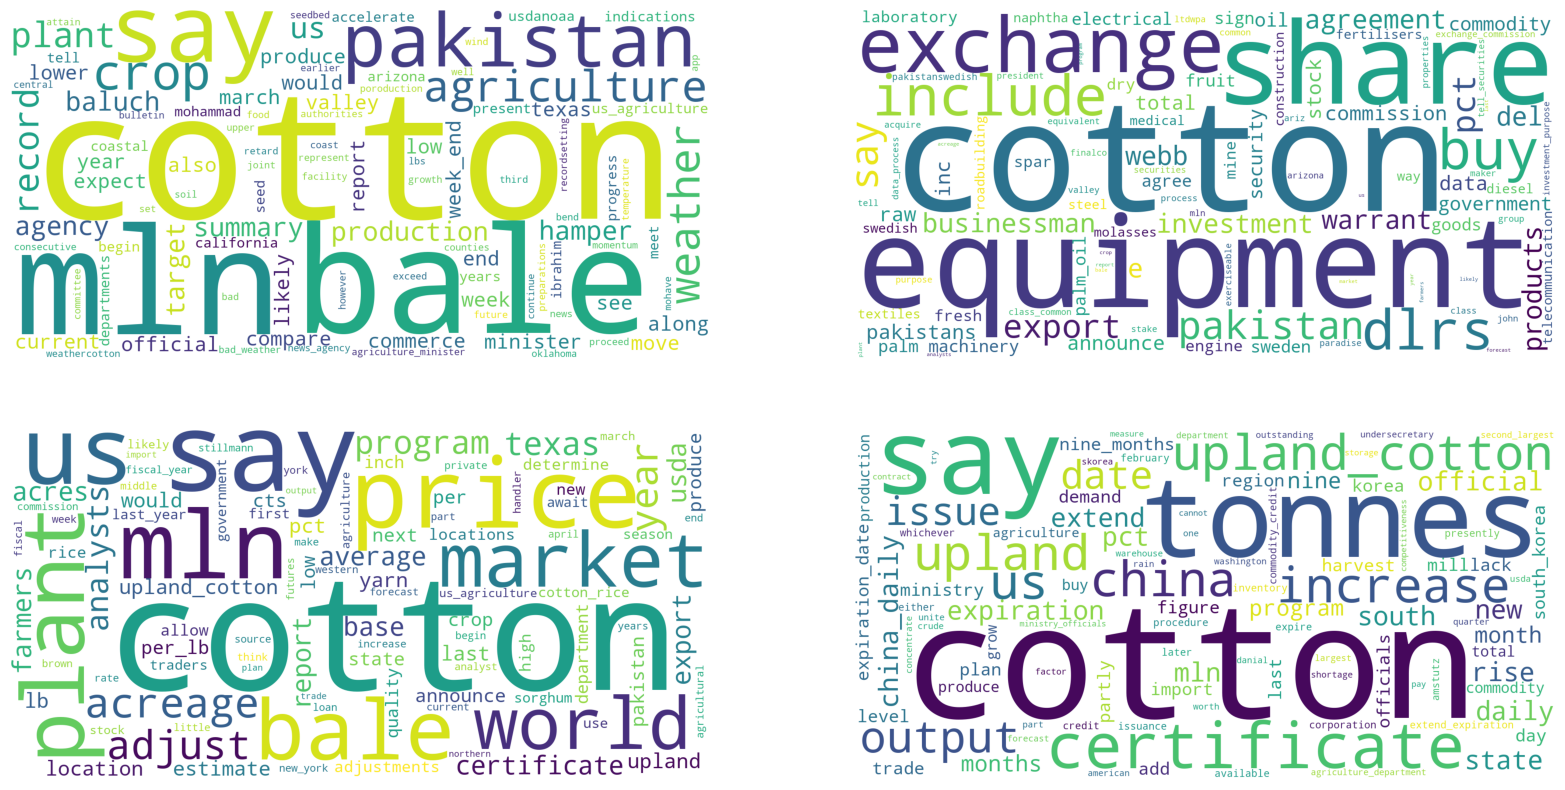

In [14]:
audo.lda_visualize_topics(lda_model, type="clouds", n_clouds=4)